# Import Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model as lm
import scipy as sc


# Load Data Frame of Selected Columns

In [2]:
C17_Conv_DF = pd.read_pickle('Output_Files/C17_Conv_DF_No_Nulls_Col.pkl')

# Select Cruise Segment

In [3]:
C17_Conv_DF = C17_Conv_DF[C17_Conv_DF['PE']==3]
#C17_Conv_DF.to_excel('C17_Conv_DF.xls')

# Select Dependent (y) and Independent (X) Variables

In [4]:
y_df = C17_Conv_DF[['FF_TOT']]
X_df = C17_Conv_DF[['GW','HP1']]

# Fit Ordinary Least Squares Linear Regression Model

In [5]:
OLSmodel = lm.LinearRegression().fit(X_df,y_df)

# Determine R^2

In [6]:
OLSmodel_R2 = OLSmodel.score(X_df,y_df)

# Display Regression Parameters

In [7]:
def DisplayRegressParams (OLSmodel, OLSmodel_R2, X_df):
    StatsList = ['Intercept']
    ValuesList = [OLSmodel.intercept_[0]]
    for count, col in enumerate(X_df.columns):
        StatsList.append(col + '_coef')
        ValuesList.append(OLSmodel.coef_[0][count])
    StatsList.append('R^2')
    ValuesList.append(OLSmodel_R2)
    statsDict = {'Stats':StatsList,'Values':ValuesList}
    Regress_Params_df = pd.DataFrame(statsDict)
    return Regress_Params_df

DisplayRegressParams(OLSmodel, OLSmodel_R2, X_df)

,Stats,Values
0,Intercept,9208.321121
1,GW_coef,0.024178
2,HP1_coef,-0.084031
3,R^2,0.138794


# Create New Regression Model with Different Independent Variables

In [8]:
X_df2 = X_df.copy()
X_df2['GW^2'] = X_df2['GW'] ** 2
X_df2['HP1^2'] = X_df2['HP1'] ** 2
X_df2['GW*HP1'] = X_df2['GW'] * X_df2['HP1']
X_df2

,GW,HP1,GW^2,HP1^2,GW*HP1
1888,481920,30976,232246886400,959512576,14927953920
1889,481920,30976,232246886400,959512576,14927953920
1890,481920,30984,232246886400,960008256,14931809280
1891,481920,30984,232246886400,960008256,14931809280
1892,481920,30984,232246886400,960008256,14931809280
...,...,...,...,...,...
24094,378240,11648,143065497600,135675904,4405739520
24095,378240,11648,143065497600,135675904,4405739520
24096,378240,11648,143065497600,135675904,4405739520
24097,378240,11648,143065497600,135675904,4405739520


# Fit New Model

In [9]:
OLSmodel2 = lm.LinearRegression().fit(X_df2,y_df)
OLSmodel2_R2 = OLSmodel2.score(X_df2,y_df)

# Display New Regression Parameters

In [10]:
DisplayRegressParams(OLSmodel2, OLSmodel2_R2, X_df2)

,Stats,Values
0,Intercept,6.269748e+04
1,GW_coef,-1.429049e-01
2,HP1_coef,-1.056799e+00
3,GW^2_coef,9.766261e-09
4,HP1^2_coef,-1.829135e-05
5,GW*HP1_coef,4.846651e-06
6,R^2,1.756051e-01


# Add Regression Models to Data Frame

In [11]:
C17_Conv_DF['REGRESS1']= OLSmodel.predict(X_df)
C17_Conv_DF['REGRESS2']= OLSmodel2.predict(X_df2)

# Melt Models to Visualize on Scatterplot

In [12]:
df_regress = C17_Conv_DF.melt(id_vars=['TIME'], value_vars=['FF_TOT', 'REGRESS1','REGRESS2'], 
                              var_name = "FF_TOT_TYPE", value_name = "FF_TOT")
df_regress

C:\Users\Adam\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  


,TIME,FF_TOT_TYPE,FF_TOT
0,13890.0,FF_TOT,20864
1,13891.0,FF_TOT,20480
2,13892.0,FF_TOT,20096
3,13893.0,FF_TOT,19712
4,13894.0,FF_TOT,19200
...,...,...,...
62404,36096.0,REGRESS2,16604.120624
62405,36097.0,REGRESS2,16604.120624
62406,36098.0,REGRESS2,16604.120624
62407,36099.0,REGRESS2,16604.120624


# Visualize

<AxesSubplot:xlabel='TIME', ylabel='HP1'>

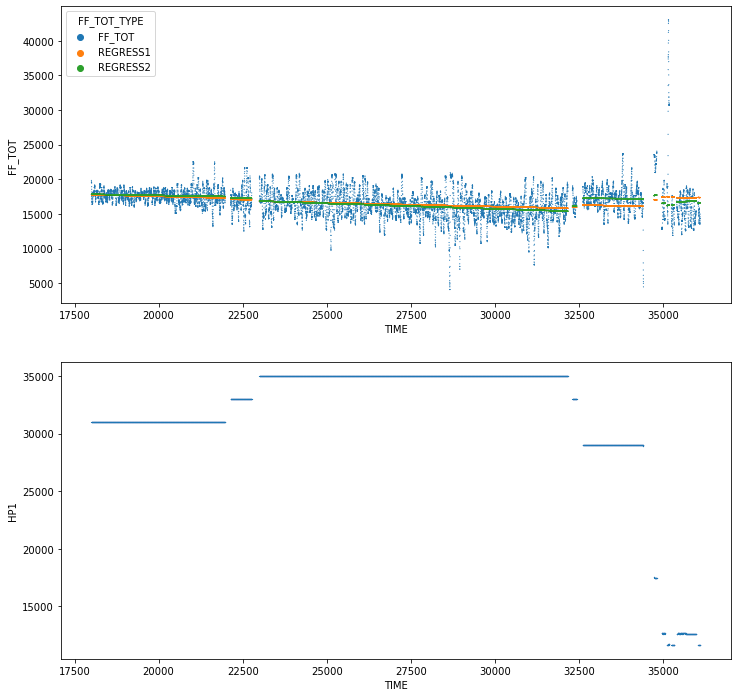

In [13]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,12))
sns.scatterplot(x='TIME', y='FF_TOT', hue='FF_TOT_TYPE', 
                data=df_regress[df_regress['TIME']>18000], s=1, edgecolor=None, ax = ax1 )
sns.scatterplot(x='TIME', y='HP1',  
                data=C17_Conv_DF[C17_Conv_DF['TIME']>18000], s=1, edgecolor=None, ax = ax2 )

# Super Class to Add Parameters Similar to Excel

In [14]:
class LinearRegression(lm.LinearRegression):

    def __init__(self,*args,**kwargs):
        # *args is the list of arguments that might go into the LinearRegression object
        # that we don't know about and don't want to have to deal with. Similarly, **kwargs
        # is a dictionary of key words and values that might also need to go into the orginal
        # LinearRegression object. We put *args and **kwargs so that we don't have to look
        # these up and write them down explicitly here. Nice and easy.

        #if not "fit_intercept" in kwargs:
        #    kwargs['fit_intercept'] = False

        super(LinearRegression,self).__init__(*args,**kwargs)

    # Adding in t-statistics for the coefficients.
    def fit(self,x,y):
        # This takes in numpy arrays (not matrices). Also assumes you are leaving out the column
        # of constants.

        # Not totally sure what 'super' does here and why you redefine self...
        self = super(LinearRegression, self).fit(x,y)
        
        StatNameList = []
        StatCategoryList = []
        StatValueList = []
        x_columns = x.columns

        self.R2 = self.score(x,y)
        self.R = self.R2**0.5
        n, k = x.shape
        self.adjR2 = (self.R2 - (k/(n-1)))*((n-1)/(n-k-1))        
       
        StatNameList = np.append(StatNameList,['Multiple R','R Square', 'Adj R Square','Observations','Reg_deg_freedom'])
        StatCategoryList = np.append(StatCategoryList,['Base','Base','Base','Base','ANOVA'])
        StatValueList = np.append(StatValueList,[self.R,self.R2,self.adjR2,n,k])     

        yHat = np.matrix(self.predict(x)).T
        ybar = y.mean()

        # Change X and Y into numpy matricies. x also has a column of ones added to it.
        x = np.hstack((np.ones((n,1)),np.matrix(x)))
        y = np.matrix(y).T

        # Degrees of freedom.
        df = float(n-k-1)

        # Sample variance.   
        sse = np.sum(np.square(yHat - y),axis=1)
        self.SSE = sse[0,0]
        self.MSE = sse[0,0]/df
        self.SE = self.MSE**0.5

        StatNameList = np.append(StatNameList,['Res_deg_freedom','SSE','MSE','Standard Error'])
        StatCategoryList = np.append(StatCategoryList,['ANOVA','ANOVA','ANOVA','ANOVA'])
        StatValueList = np.append(StatValueList,[df,self.SSE,self.MSE,self.SE])  
        
        # Sample variance for x.
        self.sampleVarianceX = x.T*x

        # Covariance Matrix = [(s^2)(X'X)^-1]^0.5. (sqrtm = matrix square root.  ugly)
        diagonalXprimeX = list(self.sampleVarianceX.astype(float).I.diagonal().flat)

        # Standard erros for the difference coefficients: the diagonal elements of the covariance matrix.
        self.seCoef  = self.SE*np.sqrt(diagonalXprimeX) 
        for count, coef in enumerate(self.seCoef):
            if count == 0:
                StatNameList = np.append(StatNameList,'Intercept_Standard_Error')
                StatCategoryList = np.append(StatCategoryList,'Coefficients')
                StatValueList = np.append(StatValueList,coef)
            else:
                StatNameList = np.append(StatNameList,x_columns[count-1]+'_Standard_Error')
                StatCategoryList = np.append(StatCategoryList,'Coefficients')
                StatValueList = np.append(StatValueList,coef)
                
        # T statistic for each beta.
        self.betasTStat = np.zeros(len(self.seCoef))
        for i in range(len(self.seCoef)):
            if i == 0:
                self.betasTStat[i] = self.intercept_/self.seCoef[i]
                StatNameList = np.append(StatNameList, 'Intercept_t_stat')
            else:
                self.betasTStat[i] = self.coef_[0][i-1]/self.seCoef[i]
                StatNameList = np.append(StatNameList, x_columns[i-1]+'_t_stat')
            StatCategoryList = np.append(StatCategoryList, 'Coefficients')
            StatValueList = np.append(StatValueList, self.betasTStat[i])                    
  

        # P-value for each beta. This is a two sided t-test, since the betas can be 
        # positive or negative.
        self.betasPValue = 2 * (1 - sc.stats.t.cdf(abs(self.betasTStat),df))
        for count, coef in enumerate(self.betasPValue):
            if count == 0:
                StatNameList = np.append(StatNameList,'Intercept_P_Value')
            else:
                StatNameList = np.append(StatNameList,x_columns[count-1]+'_P_Value')
            StatCategoryList = np.append(StatCategoryList, 'Coefficients')
            StatValueList = np.append(StatValueList, coef)         
        
        displayDict = {'Name':StatNameList,'Category':StatCategoryList,'Value':StatValueList}
        self.display_stats = pd.DataFrame(displayDict)
        
        return self

In [15]:
OLSmodel3 = LinearRegression().fit(X_df2,y_df)
OLSmodel3_R2 = OLSmodel2.score(X_df2,y_df)

OLSmodel3.display_stats

,Name,Category,Value
0,Multiple R,Base,4.190527e-01
1,R Square,Base,1.756051e-01
2,Adj R Square,Base,1.754069e-01
3,Observations,Base,2.080300e+04
4,Reg_deg_freedom,ANOVA,5.000000e+00
5,Res_deg_freedom,ANOVA,2.079700e+04
6,SSE,ANOVA,7.109723e+10
7,MSE,ANOVA,3.418629e+06
8,Standard Error,ANOVA,1.848954e+03
9,Intercept_Standard_Error,Coefficients,7.747169e+03
